# temps de debut execution

In [13]:
import time
import datetime

# Marquer le début de l'exécution
start_time = time.time()
print(f"Exécution du notebook commencée à: {datetime.datetime.now()}")


Exécution du notebook commencée à: 2024-07-09 12:46:10.671677


# Préparation des données

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import joblib
import os

# Configurer MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Credit Risk Model")

# Charger le DataFrame
app_datas = pd.read_csv('../csv_files/app_datas_light.csv')

# Mode débogage
debug_mode = True

if debug_mode:
    # Utiliser un sous-ensemble du dataset pour le débogage
    app_datas = app_datas.sample(frac=0.15, random_state=42)

# sauvegarde des identifiants clients
customer_id = app_datas['SK_ID_CURR']


# Sauvegarder la colonne 'TARGET'
target = app_datas['TARGET']

# Séparer les features et la cible
X = app_datas.drop(columns=['SK_ID_CURR', 'TARGET'])
y = app_datas['TARGET']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Créer un pipeline avec imputation KNN, standardisation et SMOTE
pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=3)),  # Imputation des valeurs manquantes
    ('scaler', StandardScaler()),  # Standardisation des caractéristiques
    ('smote', SMOTE(sampling_strategy=0.3, random_state=42))  # Équilibrage des classes avec SMOTE
])

# Appliquer le pipeline sur les données d'entraînement
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Transformer les données de test sans SMOTE
X_test_imputed = pipeline.named_steps['imputer'].transform(X_test)
X_test_scaled = pipeline.named_steps['scaler'].transform(X_test_imputed)

# création d'un dataframe imputed et scaled pour la prédiction dans l'aPI

# Utiliser les étapes d'imputation et de standardisation du pipeline existant
imputerAPI = pipeline.named_steps['imputer']
scalerAPI = pipeline.named_steps['scaler']

app_datas_to_use = app_datas.drop(columns=['SK_ID_CURR', 'TARGET'])

# Appliquer l'imputation et la standardisation sur le DataFrame
app_datas_imputed = imputerAPI.transform(app_datas_to_use)
app_datas_scaled = scalerAPI.transform(app_datas_imputed)

# Convertir le résultat en DataFrame et conserver les colonnes originales
app_datas_imputed_scaled = pd.DataFrame(app_datas_scaled, columns=app_datas_to_use.columns)

# Remettre la colonne 'TARGET' dans le DataFrame
app_datas_imputed_scaled['TARGET'] = target.values

# Remettre la colonne 'SK_ID_CURR' dans le dataframe
app_datas_imputed_scaled['SK_ID_CURR'] = customer_id.values

# Échantillonner une fraction des données
fraction = 0.05  # Prendre un dixième des données
app_datas_imputed_scaled = app_datas_imputed_scaled.sample(frac=fraction, random_state=42)

# Sauvegarder le DataFrame échantillonné dans un fichier CSV
app_datas_imputed_scaled.to_csv('../csv_files/app_datas_light_imputed_scaled.csv', index=False)

# Sauvegarder le DataFrame résultant dans un fichier CSV
# app_datas_imputed_scaled.to_csv('../csv_files/app_datas_light_imputed_scaled.csv', index=False)


print(f"Shape of X_train: {X_train_resampled.shape}")
print(f"Shape of X_test: {X_test_scaled.shape}")
print(f"Distribution in y_train: {pd.Series(y_train_resampled).value_counts(normalize=True)}")
print(f"Distribution in y_test: {pd.Series(y_test).value_counts(normalize=True)}")


Shape of X_train: (44084, 239)
Shape of X_test: (9226, 239)
Distribution in y_train: TARGET
0    0.769236
1    0.230764
Name: proportion, dtype: float64
Distribution in y_test: TARGET
0    0.918925
1    0.081075
Name: proportion, dtype: float64


In [15]:
app_datas_imputed_scaled

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM,TARGET,SK_ID_CURR
20050,-0.321917,-0.714954,0.666575,-0.574947,-0.574945,-1.064671,-1.035314,-1.035997,-0.460004,-0.475582,...,-0.080058,-0.067628,-0.529985,1.945796,-0.131686,0.960222,-0.08521,-0.465586,0,430455
29085,-0.321917,-0.714954,-1.500206,-0.574947,-0.528327,-0.188200,-0.027832,-0.233109,-0.996386,-1.293082,...,-0.080058,-0.067628,-0.529985,1.945796,-0.131686,0.960222,-0.08521,-0.465586,0,365258
16392,-0.321917,-0.714954,0.666575,-0.574947,0.124322,-0.194946,0.548630,-0.196614,0.843985,0.195723,...,-0.080058,-0.067628,-0.529985,-0.513929,-0.131686,0.960222,-0.08521,-0.465586,0,176561
36383,-0.321917,-0.714954,0.666575,-0.574947,-0.621563,-1.134119,-1.461964,-1.133317,-0.735329,0.812636,...,-0.080058,-0.067628,-0.529985,1.945796,-0.131686,0.960222,-0.08521,-0.465586,0,219345
33201,-0.321917,-0.714954,-1.500206,-0.574947,-0.980520,-0.365116,-0.696990,-0.233109,1.076797,0.991421,...,-0.080058,-0.067628,-0.529985,-0.513929,-0.131686,-1.041425,-0.08521,2.147830,0,158924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44349,-0.321917,1.398691,0.666575,-0.574947,0.823590,0.751778,0.149133,0.983389,-0.405458,0.840176,...,-0.080058,-0.067628,1.886845,-0.513929,-0.131686,0.960222,-0.08521,-0.465586,0,111602
41980,-0.321917,-0.714954,0.666575,-0.574947,-0.435092,-1.249125,-1.163902,-1.230637,0.310990,0.358673,...,-0.080058,-0.067628,-0.529985,1.945796,-0.131686,0.960222,-0.08521,-0.465586,1,419005
27839,3.106387,-0.714954,0.666575,0.794365,-0.574945,-0.811873,-0.937312,-0.719708,-1.021534,-1.880158,...,-0.080058,-0.067628,1.886845,-0.513929,-0.131686,0.960222,-0.08521,-0.465586,0,231124
30213,-0.321917,-0.714954,0.666575,-0.574947,-1.041123,-0.884694,-1.235374,-1.023832,0.128041,0.279952,...,-0.080058,-0.067628,-0.529985,1.945796,-0.131686,0.960222,-0.08521,-0.465586,0,184005


In [16]:
print(app_datas.shape)
print(app_datas.columns)

print(app_datas_imputed_scaled.shape)
print(app_datas_imputed_scaled.columns)

(46127, 241)
Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes', 'TARGET',
       'DAYS_EMPLOYED_ANOM'],
      dtype='object', length=241)
(2306, 241)
Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others',
       'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick',
       'WALLSMATERIAL_MODE_Wooden', 'EMERGENCYSTATE_MODE_No',
   

# Modélisation

## fonction model

In [17]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

def evaluate_and_log_model(model, model_name, model_type, params, X_train, y_train, X_test, y_test):
    with mlflow.start_run():
        # Entraîner le modèle
        model.fit(X_train, y_train)

        # Prédictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Évaluer les performances
        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        fp = conf_matrix[0][1]
        fn = conf_matrix[1][0]
        cost = fp + 10 * fn

        # Logger les métriques et les hyperparamètres
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Cost", cost)
        mlflow.log_params(params)
        mlflow.log_param("model_type", model_type)
        
        # Enregistrer le modèle
        mlflow.sklearn.log_model(model, model_name)
        
        print(f"{model_name} - AUC: {auc}")
        print(f"{model_name} - Accuracy: {accuracy}")
        print(f"{model_name} - Cost: {cost}")


## Modèle Dummy

In [18]:
from sklearn.dummy import DummyClassifier

dummy_params = {"strategy": "most_frequent"}
dummy_clf = DummyClassifier(**dummy_params)
evaluate_and_log_model(dummy_clf, "dummy_classifier_model", "Dummy Classifier", dummy_params, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


dummy_classifier_model - AUC: 0.5
dummy_classifier_model - Accuracy: 0.9189247778018643
dummy_classifier_model - Cost: 7480


## Modèle Regression lineaire

In [19]:
from sklearn.linear_model import LogisticRegression

log_reg_params = {
    "penalty": 'l2',
    "C": 1.0,
    "class_weight": 'balanced',
    "random_state": 42,
    "max_iter": 1000
}
log_reg = LogisticRegression(**log_reg_params)
evaluate_and_log_model(log_reg, "logistic_regression_model", "Logistic Regression", log_reg_params, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


logistic_regression_model - AUC: 0.7356613783646381
logistic_regression_model - Accuracy: 0.7023628874918708
logistic_regression_model - Cost: 5158


## Modèle Random Forrest

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    "n_estimators": 100,
    "class_weight": 'balanced',
    "random_state": 42
}
rf_clf = RandomForestClassifier(**rf_params)
evaluate_and_log_model(rf_clf, "random_forest_model", "Random Forest", rf_params, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


random_forest_model - AUC: 0.683106905826089
random_forest_model - Accuracy: 0.9187079991328854
random_forest_model - Cost: 7473


## Modèle XGBoost

In [21]:
from xgboost import XGBClassifier

xgb_params = {
    "objective": 'binary:logistic',
    "random_state": 42,
    "eval_metric": 'auc'
}
xgb_clf = XGBClassifier(**xgb_params)
evaluate_and_log_model(xgb_clf, "xgboost_model", "XGBoost", xgb_params, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


xgboost_model - AUC: 0.7102554204465032
xgboost_model - Accuracy: 0.9159982657706481
xgboost_model - Cost: 7309


## création du score personnalisé

In [22]:
from sklearn.metrics import make_scorer, confusion_matrix

# Définir une fonction pour calculer le coût
def custom_cost(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    fp = conf_matrix[0][1]
    fn = conf_matrix[1][0]
    cost = fp + 10 * fn
    return cost

# Créer un make_scorer à partir de la fonction custom_cost
cost_scorer = make_scorer(custom_cost, greater_is_better=False)


## Gridsearchcv sur XGBOost et log mlflow

In [23]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np

# Définir les hyperparamètres à tester
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 200, 300]
}

# Créer le modèle XGBoost
xgb_clf = XGBClassifier(objective='binary:logistic', random_state=42)

# Configurer GridSearchCV avec le score personnalisé
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring=cost_scorer, cv=3, verbose=2, n_jobs=-1)

# Fonction pour évaluer et enregistrer les résultats de GridSearchCV dans MLflow
def log_grid_search_cv_results(grid_search, X_train, y_train, X_test, y_test):
    with mlflow.start_run():
        # Loguer le type de modèle
        mlflow.log_param("model_type", "XGBoost with GridSearchCV")
        
        # Entraîner le GridSearchCV
        grid_search.fit(X_train, y_train)
        
        # Logger tous les résultats de GridSearchCV
        cv_results = pd.DataFrame(grid_search.cv_results_)
        for i in range(len(cv_results)):
            for key in cv_results.columns:
                value = cv_results[key].iloc[i]
                if isinstance(value, (float, int, np.number)):
                    mlflow.log_metric(f"{key}_{i}", value)
                elif isinstance(value, (list, dict)):
                    # Convert lists or dicts to a string representation
                    mlflow.log_param(f"{key}_{i}", str(value))
        
        # Enregistrer les meilleurs hyperparamètres
        best_params = grid_search.best_params_
        mlflow.log_params(best_params)
       
        
        # Afficher les meilleurs hyperparamètres
        print("Best Hyperparameters:", best_params)
        
        # Enregistrer le meilleur modèle
        best_model = grid_search.best_estimator_
        mlflow.sklearn.log_model(best_model, "best_xgboost_model")

        # Sauvegarder le modèle localement dans le dossier 'models'
        model_path = '../models/best_xgboost_model.pkl'
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        joblib.dump(best_model, model_path)
        print(f"Best model saved to {model_path}")
        
        # Prédictions avec le meilleur modèle
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]
        
        # Évaluer les performances
        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        fp = conf_matrix[0][1]
        fn = conf_matrix[1][0]
        cost = fp + 10 * fn
        
        # Logger les métriques
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Cost", cost)
        
        print(f"Best Model - AUC: {auc}")
        print(f"Best Model - Accuracy: {accuracy}")
        print(f"Best Model - Cost: {cost}")

# Exécuter la fonction pour loguer les résultats de GridSearchCV
log_grid_search_cv_results(grid_search, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 300}
Best model saved to ../models/best_xgboost_model.pkl
Best Model - AUC: 0.7104515083392942
Best Model - Accuracy: 0.9169737697810535
Best Model - Cost: 7399


## GridSearchCV avec Pipelines

L'intégration de pipelines dans le processus de GridSearch présente plusieurs avantages, notamment la simplification du flux de travail, l'élimination des fuites de données et l'automatisation des étapes de prétraitement. Voici comment et pourquoi vous pouvez intégrer des pipelines dans votre code de GridSearch.
Avantages de l'Intégration de Pipelines

    Simplification du Flux de Travail :
        En intégrant les étapes de prétraitement et de modélisation dans un pipeline, le code devient plus propre et plus facile à comprendre.

    Élimination des Fuites de Données :
        Lors de la validation croisée, il est crucial que les étapes de prétraitement soient ajustées uniquement sur les données d'entraînement et non sur les données de validation. Les pipelines assurent cette séparation.

    Automatisation et Reproductibilité :
        Les pipelines permettent d'automatiser l'ensemble du processus, garantissant que chaque étape est exécutée de manière cohérente. Cela rend également le processus reproductible.

On ajoute aussi la modification d'export des données pour l'analyse data drift avec evidently dans un autre notebook

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import os
import joblib

# Définir les étapes du pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardiser les données
    ('xgb', XGBClassifier(objective='binary:logistic', random_state=42))
])

# Définir les hyperparamètres à tester
param_grid = {
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 6, 9],
    'xgb__n_estimators': [100, 200, 300]
}

# Configurer GridSearchCV avec le pipeline
grid_search = GridSearchCV(estimator=xgb_pipeline, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)

# Fonction pour évaluer et enregistrer les résultats de GridSearchCV dans MLflow
def log_grid_search_cv_results(grid_search, X_train, y_train, X_test, y_test):
    with mlflow.start_run():
        # Loguer le type de modèle
        mlflow.log_param("model_type", "Pipeline with XGBoost and GridSearchCV")
        
        # Entraîner le GridSearchCV
        grid_search.fit(X_train, y_train)
        
        # Logger tous les résultats de GridSearchCV
        cv_results = pd.DataFrame(grid_search.cv_results_)
        for i in range(len(cv_results)):
            for key in cv_results.columns:
                value = cv_results[key].iloc[i]
                if isinstance(value, (float, int, np.number)):
                    mlflow.log_metric(f"{key}_{i}", value)
                elif isinstance(value, (list, dict)):
                    # Convert lists or dicts to a string representation
                    mlflow.log_param(f"{key}_{i}", str(value))
        
        # Enregistrer les meilleurs hyperparamètres
        best_params = grid_search.best_params_
        mlflow.log_params(best_params)
        
        # Afficher les meilleurs hyperparamètres
        print("Best Hyperparameters:", best_params)
        
        # Enregistrer le meilleur modèle
        best_model = grid_search.best_estimator_
        mlflow.sklearn.log_model(best_model, "best_pipeline_model")

        # Sauvegarder le modèle localement dans le dossier 'models'
        model_path = '../models/best_pipeline_model.pkl'
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        joblib.dump(best_model, model_path)
        print(f"Best model saved to {model_path}")
        
        # Prédictions avec le meilleur modèle
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]
        
        # Évaluer les performances
        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        fp = conf_matrix[0][1]
        fn = conf_matrix[1][0]
        cost = fp + 10 * fn
        
        # Logger les métriques
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Cost", cost)
        
        print(f"Best Model - AUC: {auc}")
        print(f"Best Model - Accuracy: {accuracy}")
        print(f"Best Model - Cost: {cost}")

        # Convertir les numpy arrays en DataFrames
        X_train_df = pd.DataFrame(X_train)
        y_train_df = pd.DataFrame(y_train, columns=['target'])
        X_test_df = pd.DataFrame(X_test)
        y_test_df = pd.DataFrame(y_test, columns=['target'])

        # Exporter les données pour l'analyse de data drift avec Evidently
        X_train_df.to_csv('../csv_files/X_train_resampled.csv', index=False)
        y_train_df.to_csv('../csv_files/y_train_resampled.csv', index=False)
        X_test_df.to_csv('../csv_files/X_test_scaled.csv', index=False)
        y_test_df.to_csv('../csv_files/y_test.csv', index=False)
        print("Data saved for data drift analysis in 'csv_files' directory.")
        
    
# Exécuter la fonction pour loguer les résultats de GridSearchCV
log_grid_search_cv_results(grid_search, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Hyperparameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 9, 'xgb__n_estimators': 200}
Best model saved to ../models/best_pipeline_model.pkl
Best Model - AUC: 0.7149038940674385
Best Model - Accuracy: 0.9185996097983958
Best Model - Cost: 7375
Data saved for data drift analysis in 'csv_files' directory.


## export données pour datadrift

In [37]:
# Convertir les numpy arrays en DataFrames
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train).reset_index(drop=True)
y_train_df.columns = ['target']
        
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test).reset_index(drop=True)
y_test_df.columns = ['target']

# Exporter les données pour l'analyse de data drift avec Evidently
X_train_df.to_csv('../csv_files/X_train_resampled.csv', index=False)
y_train_df.to_csv('../csv_files/y_train_resampled.csv', index=False)
X_test_df.to_csv('../csv_files/X_test_scaled.csv', index=False)
y_test_df.to_csv('../csv_files/y_test.csv', index=False)
print("Data saved for data drift analysis in 'csv_files' directory.")

Data saved for data drift analysis in 'csv_files' directory.


## Etude résultas model predict sur test

Ce code effectue une analyse des résultats de prédiction d'un modèle sur un jeu de données de test. Il calcule des statistiques sur les prédictions, crée une matrice de confusion, trace la courbe ROC, et calcule des métriques de performance comme la précision, le rappel, et le F1-score. Il affiche également une distribution des probabilités de prédiction et liste les identifiants de clients pour lesquels le modèle a prédit 0 ou 1.

Confusion Matrix:
[[8463   15]
 [ 736   12]]
AUC: 0.7149038940674385
Accuracy: 0.9185996097983958
Precision: 0.4444444444444444
Recall: 0.016042780748663103
F1 Score: 0.03096774193548387


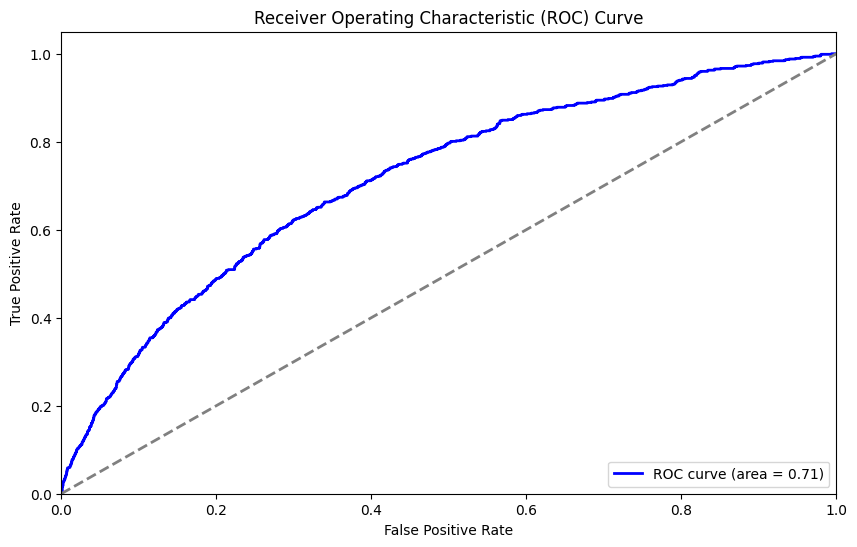

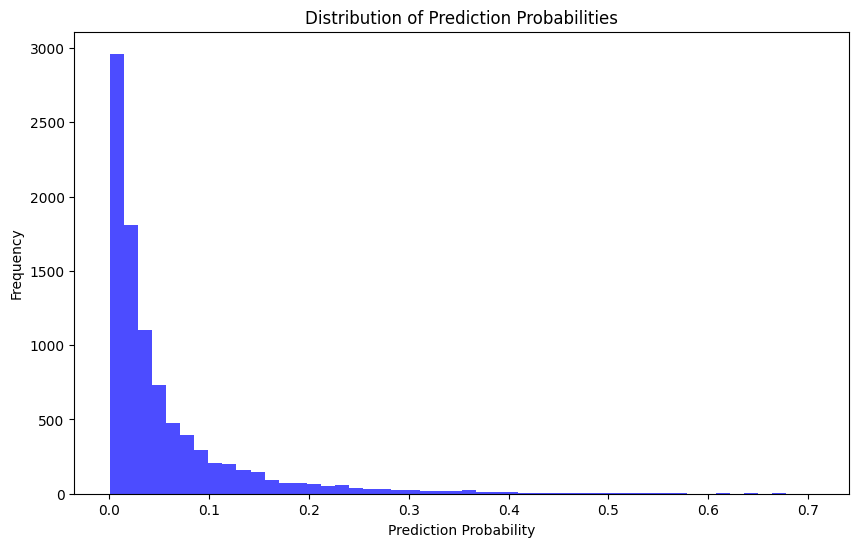

Threshold: 0.0
Confusion Matrix:
[[8463   15]
 [ 736   12]]
Precision: 0.0810752221981357
Recall: 1.0
F1 Score: 0.14998997393222377

Threshold: 0.1
Confusion Matrix:
[[8463   15]
 [ 736   12]]
Precision: 0.20124052377670573
Recall: 0.39037433155080214
F1 Score: 0.26557526148249205

Threshold: 0.2
Confusion Matrix:
[[8463   15]
 [ 736   12]]
Precision: 0.26993865030674846
Recall: 0.17647058823529413
F1 Score: 0.21341956345998384

Threshold: 0.30000000000000004
Confusion Matrix:
[[8463   15]
 [ 736   12]]
Precision: 0.3163265306122449
Recall: 0.08288770053475936
F1 Score: 0.13135593220338984

Threshold: 0.4
Confusion Matrix:
[[8463   15]
 [ 736   12]]
Precision: 0.4032258064516129
Recall: 0.03342245989304813
F1 Score: 0.06172839506172839

Threshold: 0.5
Confusion Matrix:
[[8463   15]
 [ 736   12]]
Precision: 0.4444444444444444
Recall: 0.016042780748663103
F1 Score: 0.03096774193548387

Threshold: 0.6000000000000001
Confusion Matrix:
[[8463   15]
 [ 736   12]]
Precision: 0.416666666666666

/home/alexandre/anaconda3/envs/stabadenvP7/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/anaconda3/envs/stabadenvP7/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/anaconda3/envs/stabadenvP7/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

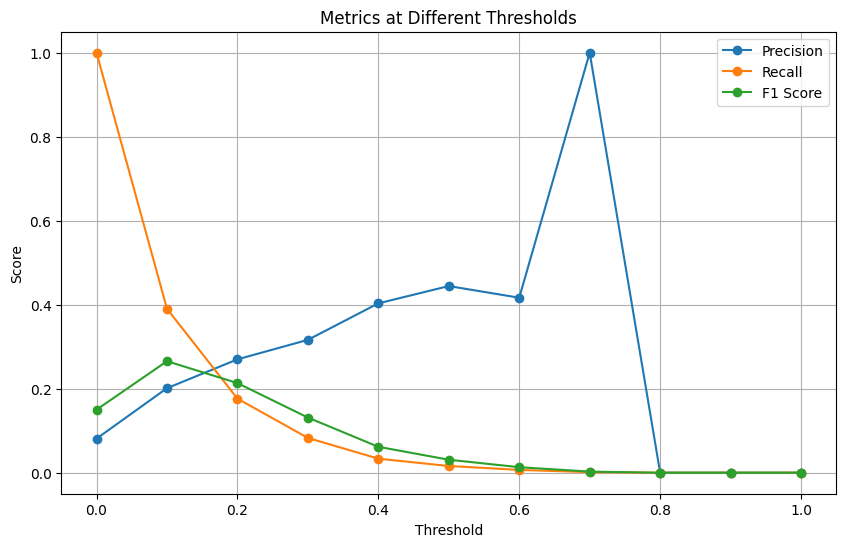

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score

# Charger le modèle sauvegardé
model_path = '../models/best_pipeline_model.pkl'
best_model = joblib.load(model_path)

# Prédire les targets sur X_test_scaled
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculer les métriques de performance
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Afficher les métriques
print("Confusion Matrix:")
print(conf_matrix)
print(f"AUC: {auc_score}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Tracer la distribution des probabilités de prédiction
plt.figure(figsize=(10, 6))
plt.hist(y_proba, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.show()

# Analyser l'importance du seuil
thresholds = np.arange(0.0, 1.1, 0.1)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred_adjusted = (y_proba >= threshold).astype(int)
    precision_adjusted = precision_score(y_test, y_pred_adjusted)
    recall_adjusted = recall_score(y_test, y_pred_adjusted)
    f1_adjusted = f1_score(y_test, y_pred_adjusted)
    
    precisions.append(precision_adjusted)
    recalls.append(recall_adjusted)
    f1_scores.append(f1_adjusted)
    
    print(f"Threshold: {threshold}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Precision: {precision_adjusted}")
    print(f"Recall: {recall_adjusted}")
    print(f"F1 Score: {f1_adjusted}\n")

# Tracer les métriques en fonction du seuil
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics at Different Thresholds')
plt.legend(loc='best')
plt.grid(True)
plt.show()

cout seuil

Threshold: 0.0
Confusion Matrix:
[[   0 8478]
 [   0  748]]
Cost: 8478

Threshold: 0.1
Confusion Matrix:
[[7319 1159]
 [ 456  292]]
Cost: 5719

Threshold: 0.2
Confusion Matrix:
[[8121  357]
 [ 616  132]]
Cost: 6517

Threshold: 0.30000000000000004
Confusion Matrix:
[[8344  134]
 [ 686   62]]
Cost: 6994

Threshold: 0.4
Confusion Matrix:
[[8441   37]
 [ 723   25]]
Cost: 7267

Threshold: 0.5
Confusion Matrix:
[[8463   15]
 [ 736   12]]
Cost: 7375

Threshold: 0.6000000000000001
Confusion Matrix:
[[8471    7]
 [ 743    5]]
Cost: 7437

Threshold: 0.7000000000000001
Confusion Matrix:
[[8478    0]
 [ 747    1]]
Cost: 7470

Threshold: 0.8
Confusion Matrix:
[[8478    0]
 [ 748    0]]
Cost: 7480

Threshold: 0.9
Confusion Matrix:
[[8478    0]
 [ 748    0]]
Cost: 7480

Threshold: 1.0
Confusion Matrix:
[[8478    0]
 [ 748    0]]
Cost: 7480



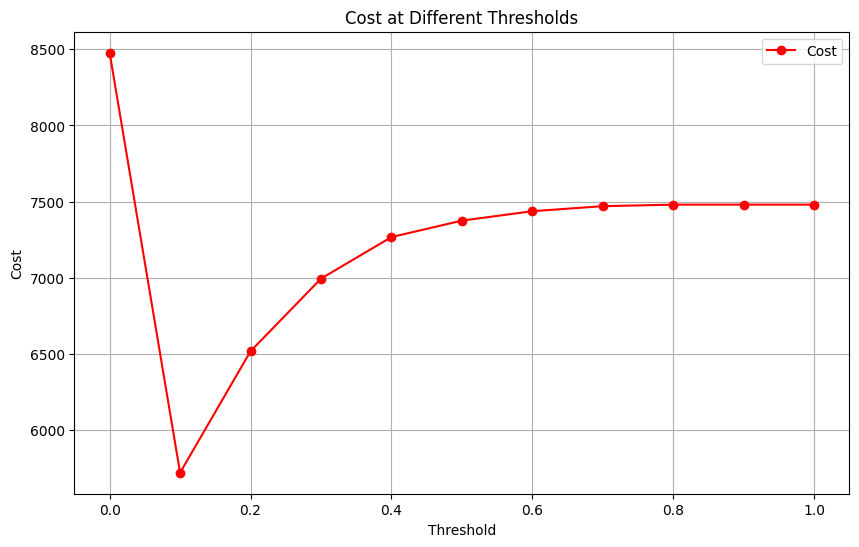

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import joblib

# Charger le modèle sauvegardé
model_path = '../models/best_pipeline_model.pkl'
best_model = joblib.load(model_path)

# Prédire les targets sur X_test_scaled
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Définir les seuils
thresholds = np.arange(0.0, 1.1, 0.1)

# Initialiser les listes pour stocker les coûts
costs = []

# Calculer le coût pour chaque seuil
for threshold in thresholds:
    y_pred_adjusted = (y_proba >= threshold).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
    fp = conf_matrix[0][1]
    fn = conf_matrix[1][0]
    cost = fp + 10 * fn
    costs.append(cost)
    print(f"Threshold: {threshold}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Cost: {cost}\n")

# Tracer les coûts en fonction du seuil
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, marker='o', color='red', label='Cost')
plt.xlabel('Threshold')
plt.ylabel('Cost')
plt.title('Cost at Different Thresholds')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## descriptions features

In [27]:
# Charger le fichier de description des colonnes avec l'encodage correct
try:
    columns_description = pd.read_csv('../csv_files/HomeCredit_columns_description.csv', encoding='utf-8')
except UnicodeDecodeError:
    columns_description = pd.read_csv('../csv_files/HomeCredit_columns_description.csv', encoding='ISO-8859-1')

# Filtrer pour obtenir uniquement les descriptions pertinentes pour les caractéristiques utilisées dans l'application {train|test}
feature_descriptions = columns_description[columns_description['Table'].str.contains('application_{train|test}.csv', na=False)]
feature_descriptions = feature_descriptions[['Row', 'Description']].set_index('Row')


# Feature importance

## globale

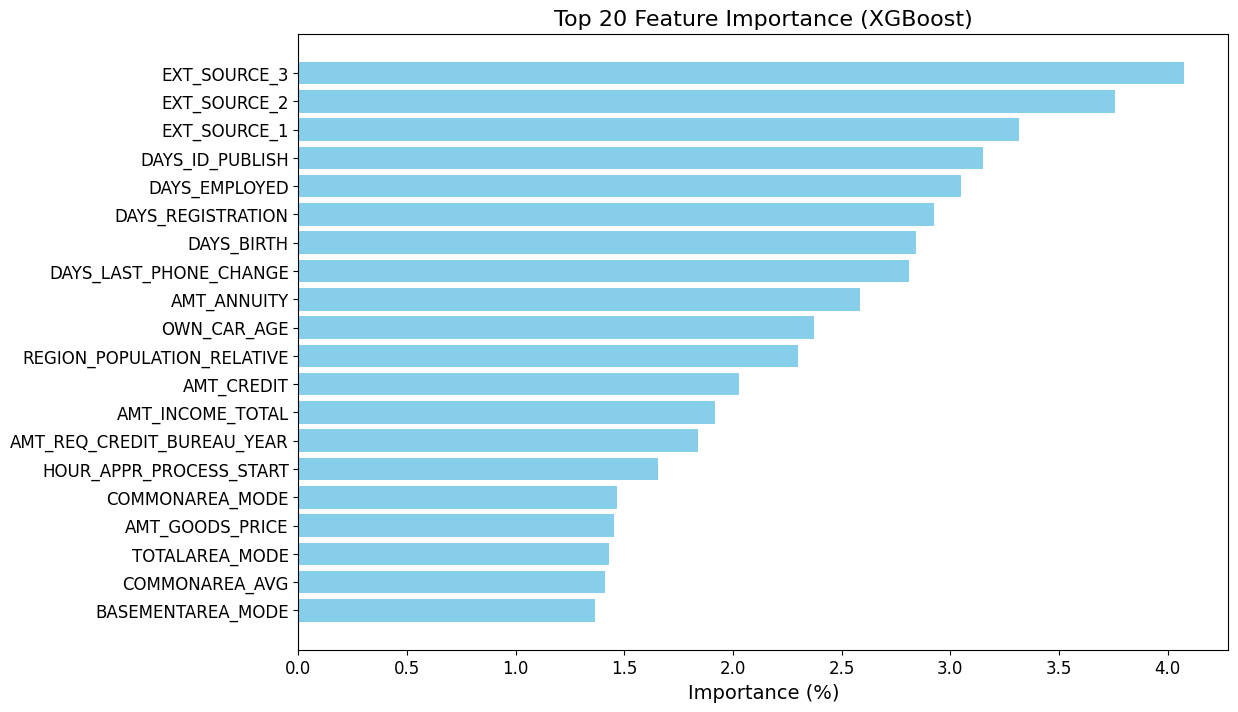

EXT_SOURCE_3: Normalized score from external data source
EXT_SOURCE_2: Normalized score from external data source
EXT_SOURCE_1: Normalized score from external data source
DAYS_ID_PUBLISH: How many days before the application did client change the identity document with which he applied for the loan
DAYS_EMPLOYED: How many days before the application the person started current employment
DAYS_REGISTRATION: How many days before the application did client change his registration
DAYS_BIRTH: Client's age in days at the time of application
DAYS_LAST_PHONE_CHANGE: How many days before application did client change phone
AMT_ANNUITY: Loan annuity
OWN_CAR_AGE: Age of client's car
REGION_POPULATION_RELATIVE: Normalized population of region where client lives (higher number means the client lives in more populated region)
AMT_CREDIT: Credit amount of the loan
AMT_INCOME_TOTAL: Income of the client
AMT_REQ_CREDIT_BUREAU_YEAR: Number of enquiries to Credit Bureau about the client one day year (exc

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBClassifier, plot_importance

# Entraîner le meilleur modèle XGBoost avec les meilleurs hyperparamètres trouvés
# best_model = grid_search.best_estimator_

#ajustement necessaire depuis qu'on utilise pipeline

# Entraîner le meilleur modèle XGBoost avec les meilleurs hyperparamètres trouvés
best_pipeline = grid_search.best_estimator_
best_model = best_pipeline.named_steps['xgb']  # Extraire le modèle XGBoost du pipeline


# Extraire l'importance des caractéristiques
importance = best_model.get_booster().get_score(importance_type='weight')

# Convertir en DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# Assigner des noms significatifs aux features basées sur leur ordre dans les données d'origine
feature_names = X_train.columns
importance_df['Feature'] = importance_df['Feature'].apply(lambda x: feature_names[int(x[1:])])

# Ajouter les descriptions des caractéristiques
importance_df['Description'] = importance_df['Feature'].map(feature_descriptions['Description'])

# Remplacer les valeurs NaN dans les descriptions par une chaîne vide pour éviter les erreurs
importance_df['Description'] = importance_df['Description'].fillna('')

# Trier les caractéristiques par importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Calculer le pourcentage d'importance
importance_df['Importance'] = 100 * (importance_df['Importance'] / importance_df['Importance'].sum())

# Afficher les 20 premières caractéristiques
top_20_features = importance_df.head(20)

plt.figure(figsize=(12, 8))  # Ajustez la taille de la figure pour plus de lisibilité
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importance (%)', fontsize=14)
plt.title('Top 20 Feature Importance (XGBoost)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()

# Afficher le graphique
plt.show()

# Afficher les descriptions des 20 premières caractéristiques
descriptions = [f"{feature}: {desc}" for feature, desc in zip(top_20_features['Feature'], top_20_features['Description'])]

# Utiliser print pour afficher les descriptions
for description in descriptions:
    print(description)


## locale

/home/alexandre/anaconda3/envs/stabadenvP7/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Crédit accepté


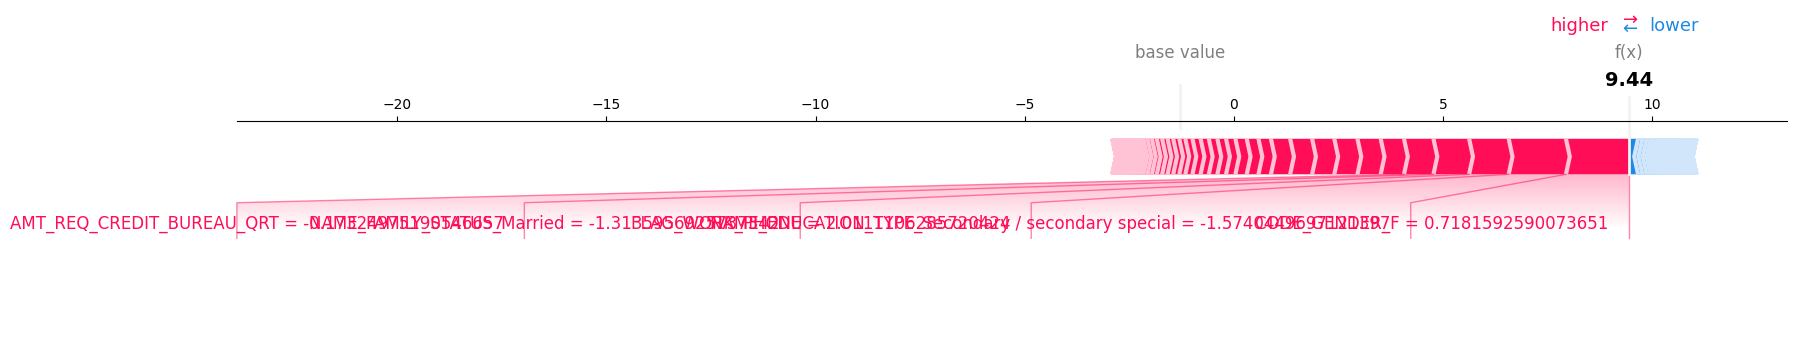

Crédit refusé


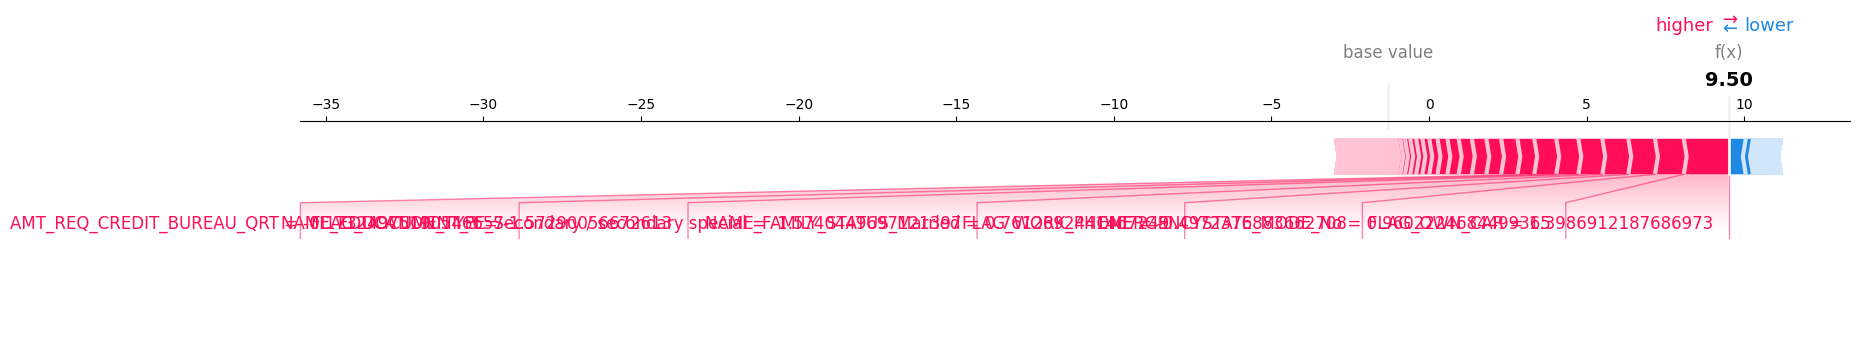

In [29]:
import shap

# Extraire le modèle XGBoost du pipeline
best_model = best_pipeline.named_steps['xgb']  # Extraire le modèle XGBoost du pipeline


# Créer un explainer SHAP pour le modèle XGBoost
explainer = shap.TreeExplainer(best_model)

# Sélectionner un client avec une cible de 0 et un client avec une cible de 1
indices_target_0 = y_test[y_test == 0].index
indices_target_1 = y_test[y_test == 1].index

# Vérifier que les indices existent
if len(indices_target_0) > 0:
    index_target_0 = indices_target_0[0]
    # Convertir l'index global en index relatif
    relative_index_target_0 = y_test.index.get_loc(index_target_0)
    X_target_0 = X_test_scaled[relative_index_target_0].reshape(1, -1)
    shap_values_target_0 = explainer.shap_values(X_target_0)
    
    # Afficher l'analyse SHAP pour un client avec une cible de 0
    print("Crédit accepté")
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values_target_0, X_target_0, feature_names=feature_names, matplotlib=True)

if len(indices_target_1) > 0:
    index_target_1 = indices_target_1[0]
    # Convertir l'index global en index relatif
    relative_index_target_1 = y_test.index.get_loc(index_target_1)
    X_target_1 = X_test_scaled[relative_index_target_1].reshape(1, -1)
    shap_values_target_1 = explainer.shap_values(X_target_1)
    
    # Afficher l'analyse SHAP pour un client avec une cible de 1
    print("Crédit refusé")
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values_target_1, X_target_1, feature_names=feature_names, matplotlib=True)


# temps de fin d'execution

In [30]:
# Marquer la fin de l'exécution
end_time = time.time()

# Calculer le temps d'exécution total
execution_time = end_time - start_time
execution_time_str = str(datetime.timedelta(seconds=execution_time))

print(f"Exécution du notebook terminée à: {datetime.datetime.now()}")
print(f"Temps d'exécution total: {execution_time_str}")


Exécution du notebook terminée à: 2024-07-09 13:27:10.314193
Temps d'exécution total: 0:40:59.642460


## Recherche id clients


In [31]:
import pandas as pd
import joblib

# Charger le DataFrame
app_datas_imputed_scaled = pd.read_csv('../csv_files/app_datas_light_imputed_scaled.csv')

# Charger le modèle
model = joblib.load("../models/best_xgboost_model.pkl")

# Séparer les features en excluant les colonnes 'TARGET' et 'SK_ID_CURR'
features = app_datas_imputed_scaled.drop(columns=['TARGET', 'SK_ID_CURR'])

# Faire les prédictions de probabilité
probabilities = model.predict_proba(features)

# Ajouter les probabilités au DataFrame
app_datas_imputed_scaled['PREDICTION_PROB'] = probabilities[:, 1]  # Probabilité d'appartenir à la classe 1

# Filtrer pour obtenir 5 clients avec une probabilité de prédiction de 1 la plus élevée
clients_with_highest_prob_1 = app_datas_imputed_scaled.nlargest(5, 'PREDICTION_PROB')

# Filtrer pour obtenir 5 clients avec une probabilité de prédiction de 0 la plus faible
clients_with_lowest_prob_1 = app_datas_imputed_scaled.nsmallest(5, 'PREDICTION_PROB')

# Afficher les résultats
print("Clients avec la plus haute probabilité de prédiction de 1:")
print(clients_with_highest_prob_1[['SK_ID_CURR', 'PREDICTION_PROB']])

print("\nClients avec la plus basse probabilité de prédiction de 1 (donc prédiction de 0):")
print(clients_with_lowest_prob_1[['SK_ID_CURR', 'PREDICTION_PROB']])


Clients avec la plus haute probabilité de prédiction de 1:
      SK_ID_CURR  PREDICTION_PROB
928       201132         0.993449
208       191547         0.986280
2296      131841         0.983883
212       243034         0.983418
900       339290         0.982534

Clients avec la plus basse probabilité de prédiction de 1 (donc prédiction de 0):
      SK_ID_CURR  PREDICTION_PROB
844       234864         0.000014
2121      196423         0.000014
1946      424195         0.000016
1045      272545         0.000016
463       210844         0.000018
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=   9.6s
[CV] END ..learning_rate=0.01, max_depth=9, n_estimators=100; total time=  33.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   5.4s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   7.8s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=  11.4s
[CV] END ...learning_rate=0.1, max_depth=6, n